In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import keras
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import save_model, load_model

In [2]:
from google.colab import files
uploaded = files.upload()

Saving processed_counts.csv to processed_counts.csv
Saving labels.csv to labels.csv


In [3]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv").rename(columns={"Unnamed: 0": "index"})
labels_pd.head()

,index,bulk_labels
0,AAAGCCTGGCTAAC-1,CD14+ Monocyte
1,AAATTCGATGCACA-1,Dendritic
2,AACACGTGGTCTTT-1,CD56+ NK
3,AAGTGCACGTGCTA-1,CD4+/CD25 T Reg
4,ACACGAACGGAGTG-1,Dendritic


In [4]:
counts_pd.head()

,index,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490


In [5]:
data = counts_pd.merge(labels_pd, how="inner", left_on="index", right_on="index")
data.head()

,index,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
2,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
3,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
4,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic


In [6]:
x = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

In [7]:
x.head()

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490


In [8]:
y.head()

0     CD14+ Monocyte
1          Dendritic
2           CD56+ NK
3    CD4+/CD25 T Reg
4          Dendritic
Name: bulk_labels, dtype: object

In [9]:
# One hot encoding of y labels
# Order chosen by proportions in sample and kept in y_labels
y_hot = pd.get_dummies(y)
y_labels = y_hot.mean(axis=0).sort_values(ascending=False).index
y_hot = y_hot[y_labels]
y_hot.head()

,Dendritic,CD14+ Monocyte,CD19+ B,CD4+/CD25 T Reg,CD8+ Cytotoxic T,CD8+/CD45RA+ Naive Cytotoxic,CD56+ NK,CD4+/CD45RO+ Memory,CD34+,CD4+/CD45RA+/CD25- Naive T
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [10]:
# 80:20 split shuffling data
x_train, x_test, y_train, y_test = train_test_split(x, y_hot, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [11]:
# Shape validation for x
x.shape, x_train.shape, x_test.shape

((700, 765), (560, 765), (140, 765))

In [12]:
# Shape validation for y
y.shape, y_train.shape, y_test.shape

((700,), (560, 10), (140, 10))

In [13]:
# Autoencoder following instructions and recommendations:
# Latent space of 32 dimensions
# 1 hidden layer for encoder and one for decoder
# L1 regularization used in fully connected layers
# Dropout used wherever possible since a very small dataset was provided...
# ...this somewhat avoids crude memorization of the train set
# Encoder will be defined later after training

encoding_dim = 32
input_dim = 765

input_obj = keras.Input(shape=(input_dim,))
dropout1 = layers.Dropout(.2)(input_obj)
hidden1 = layers.Dense(128, activation='relu', 
                       activity_regularizer=regularizers.l1(10e-5))(dropout1)
dropout2 = layers.Dropout(.2)(hidden1)
encoded = layers.Dense(encoding_dim, activation='relu', 
                       activity_regularizer=regularizers.l1(10e-5))(dropout2)
dropout3 = layers.Dropout(.2)(encoded)
hidden2 = layers.Dense(128, activation='relu')(dropout3)
dropout4 = layers.Dropout(.2)(hidden2)
decoded = layers.Dense(input_dim, activation='sigmoid')(dropout4)

autoencoder = keras.Model(input_obj, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 765)]             0         
                                                                 
 dropout (Dropout)           (None, 765)               0         
                                                                 
 dense (Dense)               (None, 128)               98048     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               4224  

In [14]:
# Configurations for improving training with the aim to reduce over-fitting 
# and also allow to seek for a lower bias model.
# Reference: https://stackoverflow.com/questions/48285129/saving-best-model-in-keras
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
mcp_save = ModelCheckpoint('autoencoder_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, min_delta=1e-4, mode='min')

In [15]:
# Used MSE as instructed
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(
    x_train, x_train,
    epochs=500,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    verbose=0,
)

In [16]:
# Load best
autoencoder = load_model('autoencoder_best.hdf5', compile=False)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Achieved under 0.95 loss (regularization is present here)
autoencoder.evaluate(x_test, x_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.9349


0.9349039196968079

In [18]:
# Encoder
encoder_output = autoencoder.layers[4].output
encoder_input = autoencoder.input
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 765)]             0         
                                                                 
 dropout (Dropout)           (None, 765)               0         
                                                                 
 dense (Dense)               (None, 128)               98048     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
Total params: 102,176
Trainable params: 102,176
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Save model
encoder.compile(optimizer='adam', loss='mean_squared_error')
save_model(encoder, 'encoder_best.hdf5', save_format='hdf5')

In [20]:
# PCA
pca32 = PCA(n_components=32)
x_pca = pca32.fit_transform(x)

In [21]:
# t-SNE
tsne2 = TSNE(n_components=2, learning_rate=200, init='random', method='exact')
x_tsne2 = tsne2.fit_transform(x)

In [22]:
# PCA to 32 dim, then t-SNE to 2 dimensions
x_pca32_tsne2 = tsne2.fit_transform(x_pca)

In [23]:
# Encoder used to get input data's latent variables
x_encoded = encoder.predict(x)
x_encoded.shape

(700, 32)

In [24]:
# Encoder to 32 dim, then PCA to 2 dim
pca2 = PCA(n_components=2)
x_encoded_pca2 = pca2.fit_transform(x_encoded)

In [25]:
# Encoder to 32 dim, then t-SNE to 2 dim
x_encoded_tsne2 = tsne2.fit_transform(x_encoded)

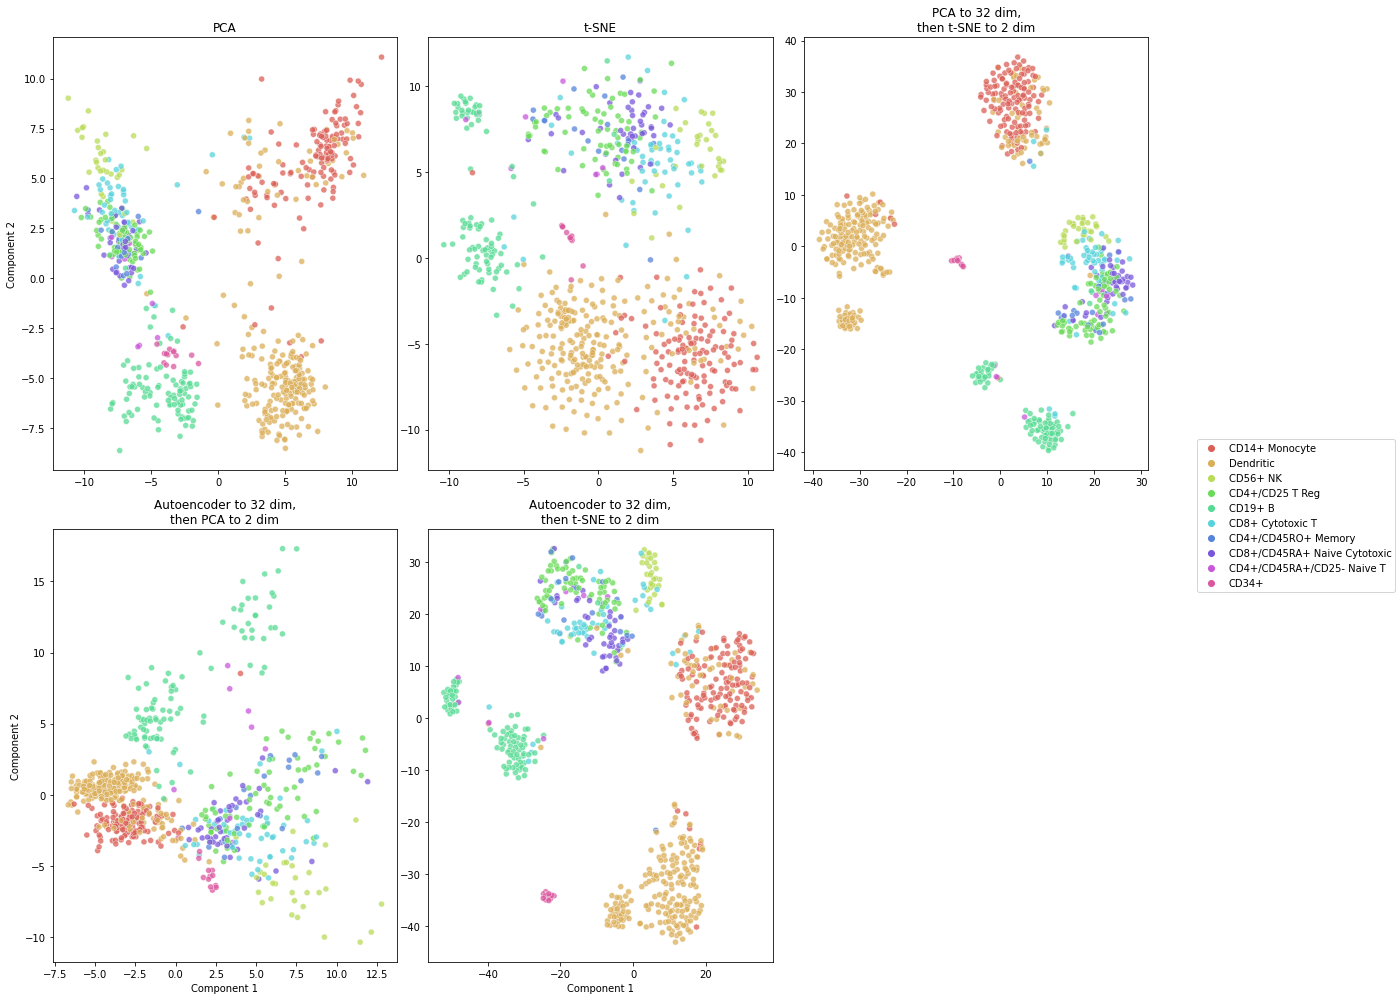

In [26]:
# Plot 2D representations
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(20, 14))

x_dict = {
    'PCA': x_pca[:, :2],
    't-SNE': x_tsne2,
    'PCA to 32 dim,\nthen t-SNE to 2 dim': x_pca32_tsne2,
    'Autoencoder to 32 dim,\nthen PCA to 2 dim': x_encoded_pca2,
    'Autoencoder to 32 dim,\nthen t-SNE to 2 dim': x_encoded_tsne2,
}

n = len(x_dict)

for i, (title, x_plot) in enumerate(x_dict.items()):

  row = i//3
  col = i%3
  ax_i = ax[row, col]

  sns.scatterplot(
      x=x_plot[:,0], y=x_plot[:,1],
      hue=y,
      palette=sns.color_palette("hls", 10),
      legend="full",
      alpha=0.75,
      ax=ax_i)
  if i == n - 1:
    handles, labels = ax_i.get_legend_handles_labels()
  ax_i.get_legend().remove()
  ax_i.set_title(title)
  if row == nrows - 1:
    ax_i.set_xlabel('Component 1')
  if col == 0:
    ax_i.set_ylabel('Component 2')

for i in range(n, nrows*ncols):

  row = i//3
  col = i%3
  ax[row, col].axis('off')

fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.4), loc='lower center', ncol=1)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

plt.savefig('projection.jpg', format='jpg')
plt.show()

## Part 2

### Cross-Validation

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [28]:
def initilize_supervised_model(size):
  """
    - Loads trained encoder
    - Adds layers according to size given (size in ['small', 'larger'])
      for supervized learning set up (label prediction)
    - Returns supervised model with untrained added layers
      but first layers, coming from encoder, are trained already
  """

  assert size in ['small', 'larger']

  # Load encoder
  encoder_load = load_model('encoder_best.hdf5', compile=False)

  # Add layers
  encoder_output = encoder_load.layers[-1].output
  encoder_input = encoder_load.input
  if size == 'small':
    # Small model
    dropout = layers.Dropout(.2)(encoder_output)
    output = layers.Dense(10, activation='softmax')(dropout)
    nn_model = keras.Model(encoder_input, output)
  elif size == 'larger':
    # Larger model
    dropout_output1 = layers.Dropout(.2)(encoder_output)
    dense_output1 = layers.Dense(16, activation='relu')(dropout_output1)
    dropout_output2 = layers.Dropout(.2)(dense_output1)
    output = layers.Dense(10, activation='softmax')(dropout_output2)
    nn_model = keras.Model(encoder_input, output)

  # Fix encoder parameters to avoid overfitting (we have only 700 data points)
  idx_not_train = [1, 2, 3, 4]
  for i in idx_not_train:
    nn_model.layers[i].trainable = False

  nn_model.compile(optimizer='adam', loss='categorical_crossentropy')

  return nn_model


In [29]:
# Small model quick validation
nn_small = initilize_supervised_model('small')
nn_small.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 765)]             0         
                                                                 
 dropout (Dropout)           (None, 765)               0         
                                                                 
 dense (Dense)               (None, 128)               98048     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                330 

In [30]:
# Larger model quick validation
nn_larger = initilize_supervised_model('larger')
nn_larger.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 765)]             0         
                                                                 
 dropout (Dropout)           (None, 765)               0         
                                                                 
 dense (Dense)               (None, 128)               98048     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528 

In [31]:
# Call backs

# Early stopping
earlyStopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=0, 
    mode='min'
)

# Reduce learning rate on plateu
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_delta=1e-4, 
    mode='min',
    verbose=0,
)

# Save best model by validation loss
def mcp_save(size):
    return ModelCheckpoint(
      f"nn_{size}_best.hdf5", 
      save_best_only=True, 
      monitor='val_loss', 
      mode='min',
    )

In [32]:
def compute_metrics(y_true, y_score, average='macro'):
  assert y_true.shape == y_score.shape
  y_ind_pred = np.argmax(y_score, axis=1)
  y_ind_true = np.argmax(y_true, axis=1)
  accuracy = metrics.accuracy_score(y_ind_true, y_ind_pred)
  precision = metrics.precision_score(y_ind_true, y_ind_pred, average=average)
  recall = metrics.recall_score(y_ind_true, y_ind_pred, average=average)
  f1 = metrics.f1_score(y_ind_true, y_ind_pred, average=average)
  roc_auc = metrics.roc_auc_score(y_true, y_score, average=average)
  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "roc_auc": roc_auc,
  }

In [33]:
# Cross validation

def nn_cross_validation(size, x, y, n_split=3):

  print(f"Cross-validation for size = {size}")

  # Stratified k-fold is used
  kfold = StratifiedKFold(n_split, shuffle=True, random_state=0)

  # Reset index
  xx = x.copy().reset_index(drop=True)
  yy = y.copy().reset_index(drop=True)
  yy_ind = np.argmax(yy.values, axis=1)

  rows = []
  for i, (train_index, test_index) in enumerate(kfold.split(xx, yy_ind)):

    # Split
    xx_train, xx_test = xx.loc[train_index], xx.loc[test_index]
    yy_train, yy_test = yy.loc[train_index], yy.loc[test_index]
    
    # Train and save model
    nn_model = initilize_supervised_model(size)
    nn_model.fit(
        xx_train, yy_train,
        epochs=500,
        batch_size=256,
        shuffle=True,
        validation_data=(xx_test, yy_test),
        callbacks=[earlyStopping, mcp_save(size), reduce_lr_loss],
        verbose=0,
    )

    # Load best model
    nn_model = load_model(f"nn_{size}_best.hdf5", compile=False)
    nn_model.compile(optimizer='adam', loss='categorical_crossentropy')

    # Assess performance
    loss = nn_model.evaluate(xx_test, yy_test, verbose=0)
    y_true = yy_test.values
    y_score = nn_model.predict(xx_test)
    row_dict = compute_metrics(y_true, y_score)
    row_dict['categorical_crossentropy'] = loss
    rows.append(row_dict)
  
  # Collect performance results
  results = pd.DataFrame.from_dict(rows, orient='columns')
  results = results.reset_index().rename(columns={'index': 'fold'})

  return results

In [34]:
# Cross-validation results for small model: folds details
res_cv_small = nn_cross_validation("small", x_train, y_train)
res_cv_small

Cross-validation for size = small


,fold,accuracy,precision,recall,f1,roc_auc,categorical_crossentropy
0,0,0.834225,0.665524,0.689300,0.675469,0.963226,0.555945
1,1,0.796791,0.620028,0.657370,0.632287,0.940926,0.696605
2,2,0.763441,0.643888,0.630672,0.627732,0.952644,0.670769


In [35]:
# Cross-validation results for larger model: folds details
res_cv_larger = nn_cross_validation("larger", x_train, y_train)
res_cv_larger

Cross-validation for size = larger


,fold,accuracy,precision,recall,f1,roc_auc,categorical_crossentropy
0,0,0.812834,0.632204,0.661662,0.643455,0.972786,0.568608
1,1,0.786096,0.616584,0.654022,0.620325,0.957949,0.641907
2,2,0.747312,0.657766,0.610384,0.601338,0.954695,0.644665


In [36]:
# Cross-validation aggregated results for both models
res_cv = pd.concat((res_cv_small.iloc[:,1:].mean(axis=0), res_cv_larger.iloc[:,1:].mean(axis=0)), axis=1).T.round(3)
res_cv.index = ['small', 'larger']
res_cv

,accuracy,precision,recall,f1,roc_auc,categorical_crossentropy
small,0.798,0.643,0.659,0.645,0.952,0.641
larger,0.782,0.636,0.642,0.622,0.962,0.618


In [37]:
print(res_cv.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  precision &  recall &     f1 &  roc\_auc &  categorical\_crossentropy \\
\midrule
small  &     0.798 &      0.643 &   0.659 &  0.645 &    0.952 &                     0.641 \\
larger &     0.782 &      0.636 &   0.642 &  0.622 &    0.962 &                     0.618 \\
\bottomrule
\end{tabular}



### Test performance

In [38]:
def plot_roc_curve(name, y_true, y_score, indices, filename=None, extension=None):

  plt.figure(figsize=(10, 7))

  # Compute and plot fpr and tpr per selected labels/indices
  for ind in indices:
    y_score_ind = y_score[:, ind]
    y_true_ind = y_true == ind
    fpr, tpr, threshold = metrics.roc_curve(y_true_ind, y_score_ind)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f"{y_labels[ind]} (AUC={roc_auc:.2f})")

  if name:
    plt.title(f'Receiver Operating Characteristic {name}')
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  if filename:
    plt.savefig(f'{filename}.{extension}', format=extension)
  plt.show()

In [39]:
# Load last model trained in cross-validation
# Training needs a validation set so any fold model is OK
nn_small = load_model(f"nn_small_best.hdf5", compile=False)
nn_larger = load_model(f"nn_larger_best.hdf5", compile=False)
nn_small.compile(optimizer='adam', loss='categorical_crossentropy')
nn_larger.compile(optimizer='adam', loss='categorical_crossentropy')

In [40]:
# Truth and predictions
y_true = y_test.values
y_true_ind = np.argmax(y_true, axis=1)
y_score_small = nn_small.predict(x_test)
y_score_larger = nn_larger.predict(x_test)

In [41]:
# Confusion matrix
conf_matrix_small = metrics.confusion_matrix(y_true_ind, np.argmax(y_score_small, axis=1))
conf_matrix_larger = metrics.confusion_matrix(y_true_ind, np.argmax(y_score_larger, axis=1))

In [42]:
def plot_confusion_matrix(name, conf_matrix, filename=None, extension=None):
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, cmap='Blues', annot=True, yticklabels=y_labels, xticklabels=y_labels)
  if name:
    plt.title(f"Confusion Matrix {name}")
  plt.xlabel("Predicted", fontsize=13)
  plt.ylabel("Actual", fontsize=13)
  if filename:
    plt.savefig(f'{filename}.{extension}', format=extension)
  plt.show()

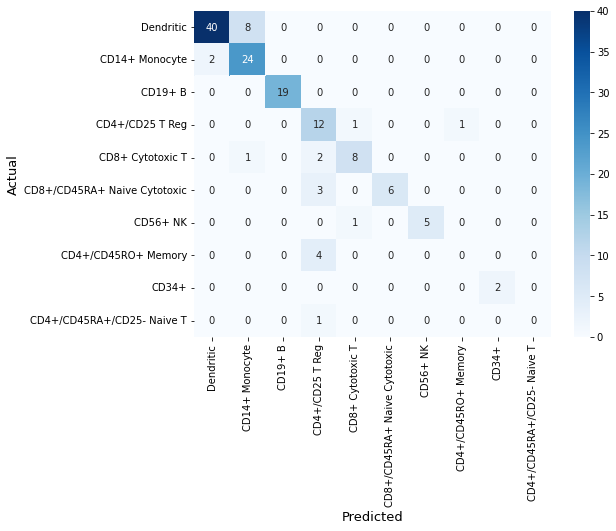

In [43]:
# Confusion matrix small model
plot_confusion_matrix(None, 
                      conf_matrix_small, 
                      'confusion_matrix_small',
                      'jpg')

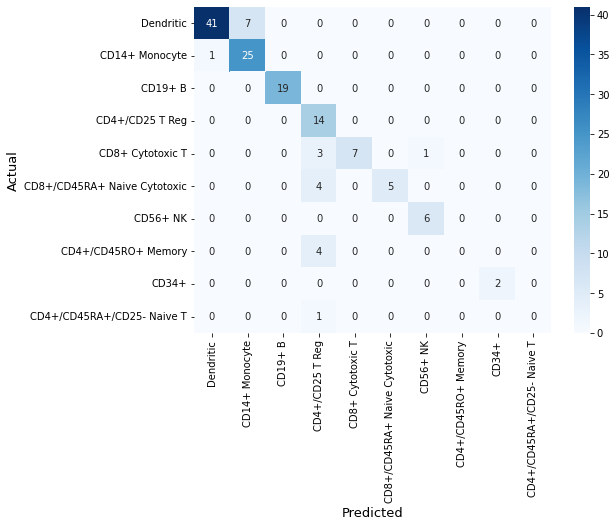

In [44]:
# Confusion matrix larger model
plot_confusion_matrix(None, 
                      conf_matrix_larger, 
                      'confusion_matrix_larger',
                      'jpg')

In [45]:
# Performance on test set
metrics_small = compute_metrics(y_true, y_score_small)
metrics_larger = compute_metrics(y_true, y_score_larger)
res = pd.DataFrame.from_dict([metrics_small, metrics_larger], 
                             orient='columns').round(3)
res.index = ['small', 'larger']
res

,accuracy,precision,recall,f1,roc_auc
small,0.829,0.703,0.684,0.684,0.971
larger,0.850,0.715,0.701,0.689,0.967


In [46]:
print(res.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  accuracy &  precision &  recall &     f1 &  roc\_auc \\
\midrule
small  &     0.829 &      0.703 &   0.684 &  0.684 &    0.971 \\
larger &     0.850 &      0.715 &   0.701 &  0.689 &    0.967 \\
\bottomrule
\end{tabular}



In [47]:
# Plot ROC curve
prop_min=0.05
label_prop = y_hot.mean(axis=0).reindex(labels)
indices = [ind for ind in range(len(labels)) if label_prop.iloc[ind] >= prop_min]
display(label_prop)
print(f"Indices to plot: {indices}")

CD14+ Monocyte                  0.184286
Dendritic                       0.342857
CD56+ NK                        0.044286
CD4+/CD25 T Reg                 0.097143
CD19+ B                         0.135714
CD8+ Cytotoxic T                0.077143
CD4+/CD45RO+ Memory             0.027143
CD8+/CD45RA+ Naive Cytotoxic    0.061429
CD4+/CD45RA+/CD25- Naive T      0.011429
CD34+                           0.018571
dtype: float64

Indices to plot: [0, 1, 3, 4, 5, 7]


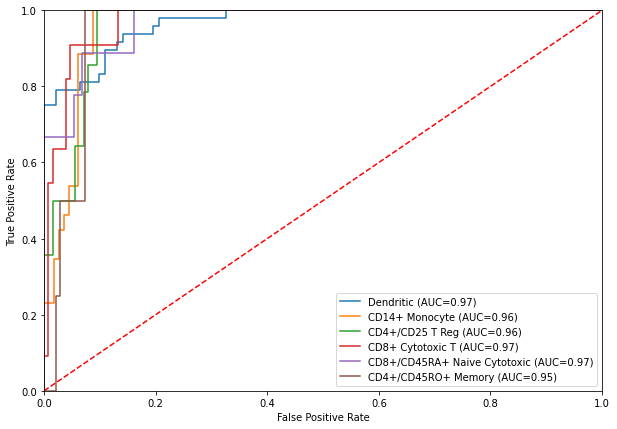

In [48]:
# ROC curve small model
plot_roc_curve(
    None, 
    y_true_ind,
    y_score_small,
    indices,
    "roc_small",
    "jpg"
)

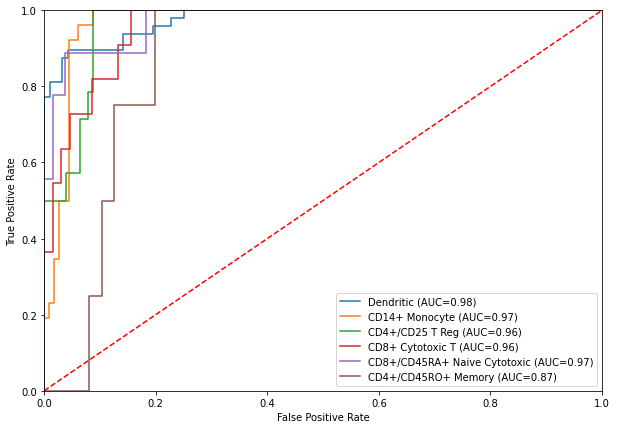

In [49]:
# ROC curve larger model
plot_roc_curve(
    None, 
    y_true_ind,
    y_score_larger,
    indices,
    "roc_larger",
    "jpg"
)